<a href="https://colab.research.google.com/github/SirArthur7/GCN-ISI-Summer-School/blob/main/Oversmoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-+.html
  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl size=279639 sha256=aee7db1b9af58e30d9ab03d484bb94a06b5aa5282dc1d702e97f157d9144c0be
  Stored in directory: /root/.cache/pip/wheels/dd/57/a3/42ea193b77378ce634eb9454c9bc1e3163f3b482a35cdee4d1
Successfully built torch-scatter
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-+.html
     |████████████████████████████████| 51 kB 197 kB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.14-cp37-cp37m-linux_x86_64.whl size=514667 sha256=66f56bddd7b442d4984212a67603d07cdf746dd1e1c183cbeda46f6cf41729e3
  Stored in directory: /root/.cache/pip/wheels/3c/aa/62/db0259eae2abce84f1ee2cf1c531bba683aab4bf79054172f8
Successfully built torch-sparse
Look

In [ ]:
from torch_geometric.datasets import Planetoid

datasets = Planetoid(root='/tmp/Cora', name='Cora')
dataset = datasets[0]

Processing...
Done!


In [ ]:
import torch 

def adj_matrix(dataset):
  adj_mat = torch.zeros([dataset.num_nodes, dataset.num_nodes])

  for i in range(dataset.num_edges):
    s = dataset.edge_index[0][i]
    t = dataset.edge_index[1][i]
    adj_mat[s][t]=1
  
  return adj_mat

def improv_adj_matrix(adj_mat):
  adj_mat += torch.eye(adj_mat.shape[0])
  return adj_mat

def norm_degree_mat(adj_mat):
  norm_diag = torch.diag(torch.sum(adj_mat, axis=1)**(-0.5))
  return norm_diag

def Lapl_norm(dataset):
  A_i = improv_adj_matrix(adj_matrix(dataset))
  D_inv = norm_degree_mat(A_i)
  L = torch.mm(D_inv,A_i)
  L= torch.mm(L,D_inv)
  return L

print(Lapl_norm(dataset))
  # print(adj_mat[500,400],adj_mat[400,500])

tensor([[0.2500, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2500, 0.2041,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2041, 0.1667,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.2000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.2000]])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
# from torchinfo import summary
  
class GCN(torch.nn.Module):

    def __init__(self, D_in_feat, H_feat, D_out_classes, num_layers):
        super(GCN, self).__init__()
        self.layers = [nn.Linear(D_in_feat, H_feat)]
        for _ in range(num_layers-2):
          self.layers.append(nn.Linear(H_feat,H_feat))
        self.layers.append(nn.Linear(H_feat, D_out_classes))
        self.layers = nn.Sequential(*self.layers)
        
        for i in range(num_layers-1):
          nn.init.kaiming_normal_(self.layers[i].weight, mode='fan_in', nonlinearity='relu')
          # nn.init.xavier_uniform_(self.layers[i].weight, gain= math.sqrt(2))        
        nn.init.xavier_uniform_(self.layers[num_layers-1].weight)
    
    def forward(self, dataset):
        x = dataset.x
        L = Lapl_norm(dataset)
        for i in range(len(self.layers)-1):
          x = torch.mm(L, x)
          # x = F.relu(self.bnorm1(self.linear1(x)))
          x = F.relu(self.layers[i](x))
          x = F.dropout(x, p = 0.5, training=self.training)
        x = torch.mm(L, x)
        x = self.layers[len(self.layers)-1](x)
        x = F.log_softmax(x, dim=1)
        return x

model1 = GCN(dataset.num_node_features,32,7,4)
print(model1.parameters)
model1.forward(dataset).shape

<bound method Module.parameters of GCN(
  (layers): Sequential(
    (0): Linear(in_features=1433, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=7, bias=True)
  )
)>


torch.Size([2708, 7])

In [ ]:
def train(model, criterion, dataset, optimizer, epochs=100):
    i = 0
    loss_and_acc = {'training_loss':[], 'validation_accuracy':[]}  

    for epoch in range(epochs):        
          model.train()
          optimizer.zero_grad()
          z = model(dataset)
          x = z[dataset.train_mask]
          y = dataset.y[dataset.train_mask]
          # print(x.shape, y.shape)
          loss = criterion(x, y)
          print(type(loss))
          loss.backward()
          optimizer.step()
          loss_and_acc['training_loss'].append(loss.data.item())
          print(epoch,"\t",loss.data.item())
            
    correct = 0
    model.eval()
    z = model(dataset)
    valid_z = z[dataset.val_mask]
    valid_y = dataset.y[dataset.val_mask]
    _, label = torch.max(valid_z, 1)
    correct += (label == valid_y).sum().item()
    print(valid_y.shape, "\t", correct)  
    accuracy = 100 * (correct / len(valid_y))
    loss_and_acc['validation_accuracy'].append(accuracy)
    
    return loss_and_acc

In [ ]:
criterion = nn.CrossEntropyLoss()
epochs = 200
learning_rate = 0.01
input_dim = dataset.num_node_features
hidden_dim = 16
output_dim = 7
num_layer = 256

model_norm  = GCN(input_dim, hidden_dim, output_dim, num_layer)
optimizer = torch.optim.Adam(model_norm.parameters(), lr=learning_rate, weight_decay = 5e-4)
training_results_Norm=train(model_norm, criterion, dataset, optimizer, epochs)

<class 'torch.Tensor'>
0 	 1095.2098388671875
<class 'torch.Tensor'>
1 	 677.9274291992188
<class 'torch.Tensor'>
2 	 214.1556854248047
<class 'torch.Tensor'>
3 	 2.4839682579040527
<class 'torch.Tensor'>
4 	 2.9291012287139893
<class 'torch.Tensor'>
5 	 2.117098808288574
<class 'torch.Tensor'>
6 	 1.9469804763793945
<class 'torch.Tensor'>
7 	 1.9933924674987793
<class 'torch.Tensor'>
8 	 110.6950912475586
<class 'torch.Tensor'>
9 	 1.9327902793884277
<class 'torch.Tensor'>
10 	 1.9459433555603027
<class 'torch.Tensor'>
11 	 1.9856561422348022
<class 'torch.Tensor'>
12 	 3.9179251194000244
<class 'torch.Tensor'>
13 	 1.944671630859375
<class 'torch.Tensor'>
14 	 1.9431904554367065
<class 'torch.Tensor'>
15 	 1.9816641807556152
<class 'torch.Tensor'>
16 	 2.000216484069824
<class 'torch.Tensor'>
17 	 1.9400174617767334
<class 'torch.Tensor'>
18 	 1.9418877363204956
<class 'torch.Tensor'>
19 	 1.9384303092956543
<class 'torch.Tensor'>
20 	 1.9322808980941772
<class 'torch.Tensor'>
21 	 1

KeyboardInterrupt: ignored

In [ ]:
from matplotlib import pyplot as plt

x = [i+1 for i in range(200)] 
y = training_results_Norm['training_loss']

print(training_results_Norm['validation_accuracy'])
plt.figure(figsize=(32, 8), dpi=200)
plt.scatter(x, y, c ="blue")
 
plt.show()

In [ ]:
PATH = "state_dict_model.pt" 
torch.save(model_norm.state_dict(), PATH)

model = GCN(input_dim, hidden_dim, output_dim, num_layer)
model.load_state_dict(torch.load(PATH))

model.eval()
z = model(dataset)
test_z = z[dataset.test_mask]
test_y = dataset.y[dataset.test_mask]

correct = 0
_, label = torch.max(test_z, 1)
correct += (label == test_y).sum().item()
print(test_y.shape, "\t", correct)
test_acc = 100 * (correct / len(test_y))
print(test_acc)

from sklearn.manifold import TSNE

colors = []
for i in range(len(test_z)):
  if test_y[i]==0:
    colors.append("orange");
  elif test_y[i]==1:
    colors.append("red");
  elif test_y[i]==2:
    colors.append("green");
  elif test_y[i]==3:
    colors.append("violet");
  elif test_y[i]==4:
    colors.append("limegreen");
  elif test_y[i]==5:
    colors.append("blue");
  elif test_y[i]==6:
    colors.append("yellow");

tsne = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_results = tsne.fit_transform(test_z.detach().numpy())

plt.figure(figsize=(6, 4))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c= colors)

In [ ]:
datasets2 = Planetoid(root='/tmp/CiteSeer', name='CiteSeer')
dataset2 = datasets2[0]

criterion = nn.CrossEntropyLoss()
epochs = 200
learning_rate = 0.01
input_dim = dataset2.num_node_features
hidden_dim = 16
output_dim = 6
num_layer = 1024

model_norm  = GCN(input_dim, hidden_dim, output_dim, num_layer)
optimizer = torch.optim.Adam(model_norm.parameters(), lr=learning_rate, weight_decay = 5e-4)
training_results_Norm=train(model_norm, criterion, dataset2, optimizer, epochs)

Processing...
Done!


<class 'torch.Tensor'>
0 	 6.325865602938307e+17
<class 'torch.Tensor'>
1 	 17436581888.0
<class 'torch.Tensor'>
2 	 29.958698272705078
<class 'torch.Tensor'>
3 	 8.119136810302734
<class 'torch.Tensor'>
4 	 6.974127769470215
<class 'torch.Tensor'>
5 	 119.38877868652344
<class 'torch.Tensor'>
6 	 2.886352300643921
<class 'torch.Tensor'>
7 	 1.903768539428711
<class 'torch.Tensor'>
8 	 3.193369150161743
<class 'torch.Tensor'>
9 	 1.7944297790527344
<class 'torch.Tensor'>
10 	 1.8422412872314453
<class 'torch.Tensor'>
11 	 1.854284405708313
<class 'torch.Tensor'>
12 	 1.9477477073669434
<class 'torch.Tensor'>
13 	 2.5784192085266113
<class 'torch.Tensor'>
14 	 1.9470703601837158
<class 'torch.Tensor'>
15 	 1.8208383321762085
<class 'torch.Tensor'>
16 	 2.261073589324951
<class 'torch.Tensor'>
17 	 1.8063828945159912
<class 'torch.Tensor'>
18 	 1.8205515146255493
<class 'torch.Tensor'>
19 	 1.8020488023757935
<class 'torch.Tensor'>
20 	 2.264711856842041
<class 'torch.Tensor'>
21 	 1.821

[13.0]


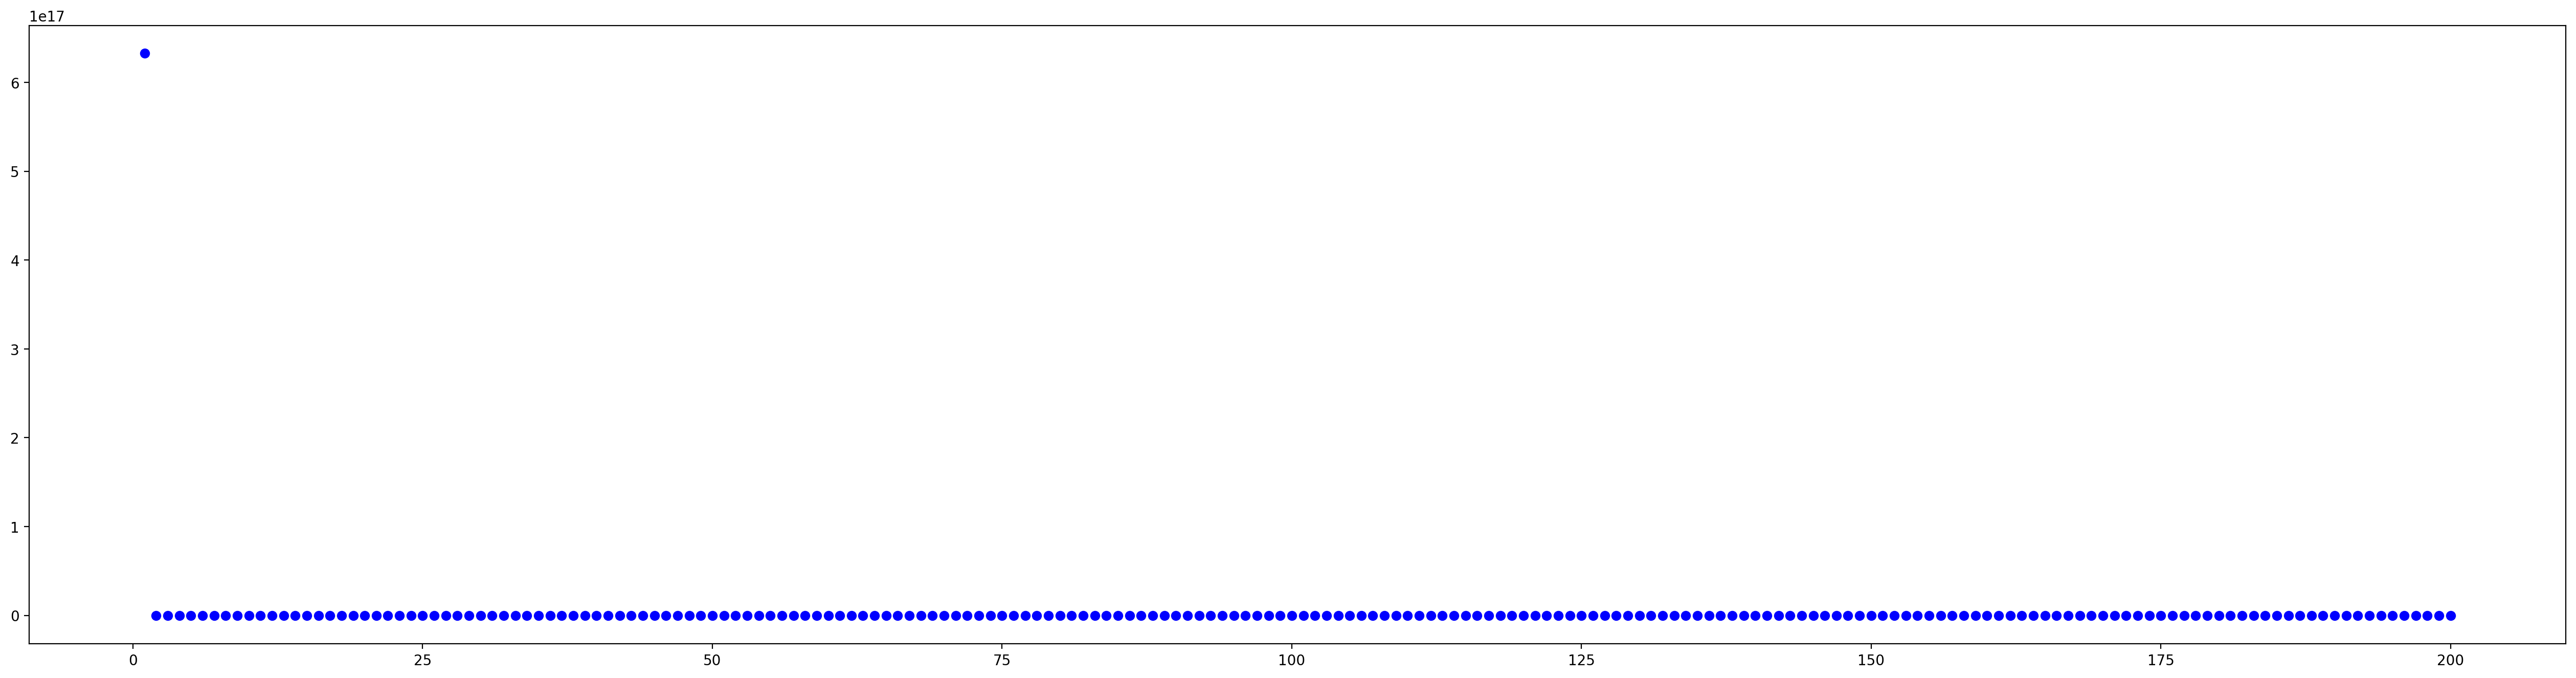

In [ ]:
from matplotlib import pyplot as plt

x = [i+1 for i in range(200)] 
y = training_results_Norm['training_loss']

print(training_results_Norm['validation_accuracy'])
plt.figure(figsize=(32, 8), dpi=200)
plt.scatter(x, y, c ="blue")
 
plt.show()

torch.Size([1000]) 	 122
12.2


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


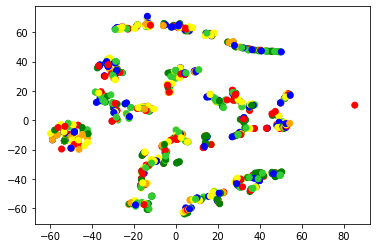

In [ ]:
PATH = "state_dict_model2.pt" 
torch.save(model_norm.state_dict(), PATH)

model = GCN(input_dim, hidden_dim, output_dim, num_layer)
model.load_state_dict(torch.load(PATH))

model.eval()
z = model(dataset2)
test_z = z[dataset2.test_mask]
test_y = dataset2.y[dataset2.test_mask]

correct = 0
_, label = torch.max(test_z, 1)
correct += (label == test_y).sum().item()
print(test_y.shape, "\t", correct)
test_acc = 100 * (correct / len(test_y))
print(test_acc)

from sklearn.manifold import TSNE

colors = []
for i in range(len(test_z)):
  if test_y[i]==0:
    colors.append("orange");
  elif test_y[i]==1:
    colors.append("red");
  elif test_y[i]==2:
    colors.append("green");
  elif test_y[i]==3:
    colors.append("yellow");
  elif test_y[i]==4:
    colors.append("limegreen");
  elif test_y[i]==5:
    colors.append("blue");

tsne = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_results = tsne.fit_transform(test_z.detach().numpy())

plt.figure(figsize=(6, 4))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c= colors)